In [11]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
import scipy.optimize as opt
from statsmodels.tsa.arima_process import arma_generate_sample
import pandas as pd
from datetime import datetime, timedelta

In [15]:
class pci_generator:

    def __init__(self, N, alpha, beta, rho, sigma_M, sigma_R, sigma_X):
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.sigma_M = sigma_M
        self.sigma_R = sigma_R
        self.sigma_X = sigma_X

    def generate_pci(self):
        '''
        Generate two partially cointegrated time series of length N with given parameters, such that:
            - X_2,t = alpha + beta * X_1,t + W_t
            - W_t = M_t + R_t
            - M_t = rho * M_t-1 + eps(M_t)
            - R_t = R_t-1 + eps(R_t)
            - eps(M_t) ∼ NID(0, sigma_M)
            - eps(R_t) ∼ NID(0, sigma_R)

        Parameters:
        N (int): Length of the time series to generate.
        alpha (float): intercept
        beta (float): cointegration coefficient.
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.
        sigma_X (float): white noise variance of X1.

        Returns:
        tuple: A tuple containing two cointegrated time series, X1 and X2, which are numpy.ndarray.
        '''

        ret_X1 = self.sigma_X * np.random.randn(self.N)
        X1 = 100 * np.exp(np.cumsum(ret_X1))  # generate X1
        W, M, R = self._generate_par()  # generate PAR residual
        X2 = self.alpha + self.beta * X1 + W  # compute X2

        return X1, X2, W, M, R
    
    def _generate_par(self):
        '''
        Generate PAR sample of length N with parameters rho, sigma_M, sigma_R

        Parameters:
        N (int): Length of the time series to generate.
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        numpy.ndarray: A partial autoregressive time series
        '''

        ar_M = [1, -self.rho]
        ar_R = [1, -1]
        ma = [1]

        M = arma_generate_sample(ar_M, ma, self.N, scale=self.sigma_M)
        R = arma_generate_sample(ar_R, ma, self.N, scale=self.sigma_R)
        S = M + R
        return S, M, R

In [16]:
class pci_pair:

    def __init__(self, X1, X2):
        self.X1 = X1
        self.X2 = X2

    def fit_pci(self, tol=0.001):
        '''
        Fit partial cointegrated model to time series X1 and X2 such that:
            - X_2,t = alpha + beta * X_1,t + W_t
            - W_t = M_t + R_t
            - M_t = rho * M_t-1 + eps(M_t)
            - R_t = R_t-1 + eps(R_t)
            - eps(M_t) ∼ NID(0, sigma_M)
            - eps(R_t) ∼ NID(0, sigma_R)

        Parameters:
        X1 (numpy.ndarray): time series
        X2 (numpy.ndarray): time series, supposedly partially cointegrated with X1

        Returns:
        alpha (float): estimated value for alpha
        beta (float): estimated value for beta
        rho (float): estimated AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): estimated white noise variance of mean reverting component .
        sigma_R (float): estimated white noise variance of random walk component.
        '''

        # calculate initial guess for beta
        results = self.fit_ols_on_diff()
        beta_i = results

        # calculate initial guess for alpha
        alpha_i = self.X2[0] - beta_i * self.X1[0]

        # calculate residuals W and initial guesses for rho, sigma_M, sigma_R
        W = self.X2 - alpha_i - beta_i * self.X1

        params_i = self.fit_mle(W)

        # perform optimization
        x_i = (alpha_i, beta_i, *params_i)  # initial guess
        res = opt.minimize(self.f_to_min_pci, x_i, args=(self.X1, self.X2), tol=tol)
        alpha, beta, rho, sigma_M, sigma_R = res.x
        ll = -res.fun

        W = self.X2 - alpha - beta * self.X1

        setattr(self, "beta", beta)
        setattr(self, "alpha", alpha)
        setattr(self, "rho", rho)
        setattr(self, "sigma_M", sigma_M)
        setattr(self, "sigma_R", sigma_R)
        setattr(self, "W", W)

    def fit_mle(self, W, tol=0.001):
        '''
        fit model using Maximum Likelihood estimation. This is used on the residuals W_t of the linear regression of X1 on X2.

        Parameters:
        X (numpy.ndarray): A partial suspected autoregressive time series

        Returns:
        rho (float): estimated value of rho
        sigma_M (float): estimated value of sigma_M
        sigma_R (float): estimated value of sigma_R
        '''

        estimates = []
        lls = []

        # distribution for random guesses
        rnd_rho = stats.uniform(loc=-1, scale=2)

        # get initial guesses using lagged variances
        x_i = self.lagvar_estimate_par(W)

        # set boundaries
        bounds = ((-1, 1), (0, np.inf), (0, np.inf))

        # function to generate random initial values
        std = np.std(np.diff(W))
        rnd_sigma = stats.norm(loc=std, scale=std / 2)

        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()

        # minimize
        res = opt.minimize(self.f_to_min_par , x0=(x_i), args=(W), bounds=bounds, tol=tol)

        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun)  # save log-likelihood

        # repeat minimization with different (random) initial values
        n_att = 0
        while len(lls) < 10 and n_att < 100:
            n_att += 1
            x0 = gen_x0()
            res = opt.minimize(self.f_to_min_par, x0=(x0), args=(W), bounds=bounds, tol=tol)
            if res.success:
                estimates.append(res.x)
                lls.append(-res.fun)  # save log-likelihood

        try:
            argmax = np.argmax(lls)  # index of the biggest likelihood
            return estimates[argmax]
        except:
            # print('Estimation failed!')
            return len(x0) * [np.nan]  # return nans

    def lagvar_estimate_par(self, W):
        '''
        estimate parameters of partial AR model using lagged variances. used for inital estimation of parameters

        Parameters
        X (numpy.ndarray): A partial autoregressive time series

        Returns:
        rho_lv (float): estimated value for rho
        sigma_M_lv (float): estimated value for sigma_M
        sigma_R_lv (float): estimated value for sigma_R
        '''

        # calculate lagged variances
        v1 = np.var(W[1:] - W[:-1])
        v2 = np.var(W[2:] - W[:-2])
        v3 = np.var(W[3:] - W[:-3])

        # rho
        rho_lv = -(v1 - 2 * v2 + v3) / (2 * v1 - v2)

        # sigma_M
        if (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1) > 0:
            sigma_M_lv = np.sqrt(1 / 2 * (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1))
        else:
            sigma_M_lv = 0

        # sigma_R
        if v2 > 2 * sigma_M_lv ** 2:
            sigma_R_lv = np.sqrt(1 / 2 * (v2 - 2 * sigma_M_lv ** 2))
        else:
            sigma_R_lv = 0

        return rho_lv, sigma_M_lv, sigma_R_lv

    def fit_ols_on_diff(self):
        '''
        Fits an OLS model on the first differences of time series X1 and X2

        Parameters:
        X1 (numpy.ndarray): A time-series
        X2 (numpy.ndarray): A time-series

        Returns:
        results.params[0]: returns the Beta value of our OLS fit
        '''
        ret_X1 = np.diff(self.X1)
        ret_X2 = np.diff(self.X2)

        results = sm.OLS(ret_X2, ret_X1).fit()

        return results.params[0]

    def kalman_estimate(self, W, rho, sigma_M, sigma_R):
        '''
        Calculate estimates of mean-reverting and random walk components.

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        M (numpy.ndarray): An estimate of the mean reverting component of our time series
        R (numpy.ndarray): An estimate of the random walk component of our time series
        eps (numpy.ndarray): Prediction errors for each time step
        '''

        # create arrays for storing both components and prediction errors
        M = np.zeros(len(W))
        R = np.zeros(len(W))
        eps = np.zeros(len(W))

        # set initial state
        if sigma_R == 0:
            M[0] = W[0]
            R[0] = 0
        else:
            M[0] = 0
            R[0] = W[0]

        # calculate Kalman gain
        if sigma_M == 0:
            K_M = 0
            K_R = 1
        elif sigma_R == 0:
            K_M = 1
            K_R = 0
        else:
            sqr = np.sqrt((1 + rho) ** 2 * sigma_R ** 2 + 4 * sigma_M ** 2)
            K_M = 2 * sigma_M ** 2 / (sigma_R * (sqr + rho * sigma_R + sigma_R) + 2 * sigma_M ** 2)
            K_R = 2 * sigma_R / (sqr - rho * sigma_R + sigma_R)

        # calculate estimates
        for i in range(1, len(W)):
            xhat = rho * M[i - 1] + R[i - 1]
            eps[i] = W[i] - xhat
            M[i] = rho * M[i - 1] + eps[i] * K_M
            R[i] = R[i - 1] + eps[i] * K_R

        setattr(self, "M", M)
        setattr(self, "R", R)

        return eps

    def calc_log_like(self, W, rho, sigma_M, sigma_R):
        '''
        Compute log likelihood function

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        ll (float): Value of the log likelihood, a measure of goodness of fit for our model
        '''

        N = len(W)
        eps = self.kalman_estimate(W, rho, sigma_M, sigma_R)
        ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
                2 * (sigma_M ** 2 + sigma_R ** 2)) * np.sum(eps[1:] ** 2)

        return ll

    def f_to_min_par(self, x_i, X):
        rho, sigma_M, sigma_R = x_i
        '''
        Define the function to minimize for PAR model
        '''
        return -self.calc_log_like(X, rho, sigma_M, sigma_R)

    def f_to_min_pci(self, x_i, X1, X2):
        '''
        Define function to minimize
        '''
        alpha, beta, rho, sigma_M, sigma_R = x_i
        W = X2 - beta * X1 - alpha
        return -self.calc_log_like(W, rho, sigma_M, sigma_R)

    def calculate_Rsq(self):
        '''
        Calculate R^2 - proportion of variance attributable to mean reversion
        '''
        return (2 * self.sigma_M ** 2) / (2 * self.sigma_M ** 2 + (1 + self.rho) * self.sigma_R ** 2)

In [17]:
def trading_parameters(X1, X2, window_size):

    t = 0
    eli = None

    # indicators of long/short positions
    short = False
    long = False

    base = datetime.today()
    date_list = [base - timedelta(days=x) for x in range(len(X1))]
    date_list.reverse()

    # Combine the input time series into a DataFrame
    time_series =  pd.DataFrame({"X1": X1, "X2": X2}, index=(date_list))

    # Create an empty DataFrame to store parameters of the fitted pci model and the pairs eligibility
    pci_parameters = pd.DataFrame(columns=["alpha", "beta", "rho", "sigma_M",
                                           "sigma_R", "W", "Rsq", "Eligibility"],
                                  index=(date_list[window_size-1:]))

    # Create an empty DataFrame to store trade signals, position sizing, and orders
    trade_parameters = pd.DataFrame(columns=["M_t", "M_t / sigma_M",
                                            "Short", "Long",
                                            "Hedge Ratio", "X2: Short Open Price", "X1: Short Open Price",
                                             "X2: Short Close Price", "X1: Short Close Price",
                                             "X2: Long Open Price", "X1: Long Open Price",
                                             "X2: Long Close Price", "X1: Long Close Price"
                                             ], index=(date_list[window_size-1:]))
    for window in time_series.rolling(window=window_size):
        if len(window) < window_size:
            continue

        pci = pci_pair(window["X1"].to_numpy(), window["X2"].to_numpy())
        pci.fit_pci()
        pci.kalman_estimate(pci.W, pci.rho, pci.sigma_M, pci.sigma_R)
        rsq = pci.calculate_Rsq()

        if pci.rho > 0.5 and rsq > 0.5:
            eli = True
        else:
            eli = False

        pci_parameters.loc[pci_parameters.index.to_list()[t]] = [
            pci.alpha,
            pci.beta,
            pci.rho,
            pci.sigma_M,
            pci.sigma_R,
            pci.W[-1],
            rsq,
            eli
        ]

        pos = pci.M[-1] / pci.sigma_M

        short_open_price_X2, short_open_price_X1, short_close_price_X2, short_close_price_X1 = np.nan, np.nan, np.nan, np.nan
        long_open_price_X2, long_open_price_X1, long_close_price_X2, long_close_price_X1 = np.nan, np.nan, np.nan, np.nan

        if short is False and pos > 2 :
            short = True
            short_open_price_X2 = time_series["X2"][time_series.index.to_list()[t+window_size-1]]
            short_open_price_X1 = time_series["X1"][time_series.index.to_list()[t+window_size-1]]
        if short is True and pos < 0:
            short = False
            short_close_price_X2 = time_series["X2"][time_series.index.to_list()[t+window_size-1]]
            short_close_price_X1 = time_series["X1"][time_series.index.to_list()[t+window_size-1]]
        if long is False and pos < -2:
            long = True
            long_open_price_X2 = time_series["X2"][time_series.index.to_list()[t+window_size-1]]
            long_open_price_X1 = time_series["X1"][time_series.index.to_list()[t+window_size-1]]
        if long is True and pos > 0:
            long = False
            long_close_price_X2 = time_series["X2"][time_series.index.to_list()[t+window_size-1]]
            long_close_price_X1 = time_series["X1"][time_series.index.to_list()[t+window_size-1]]


        hedge_ratio = pci.beta * pci.X1[-1] / pci.X2[-1]

        trade_parameters.loc[trade_parameters.index.to_list()[t]] = [
            pci.M[-1],
            pos,
            short,
            long,
            hedge_ratio,
            short_open_price_X2,
            short_open_price_X1,
            short_close_price_X2,
            short_close_price_X1,
            long_open_price_X2,
            long_open_price_X1,
            long_close_price_X2,
            long_close_price_X1
        ]

        t+=1

    return trade_parameters[["Short", "Long"]]

C:\Users\gagne\AppData\Local\Temp\ipykernel_19772\3292985946.py:234: RuntimeWarning: divide by zero encountered in log
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19772\3292985946.py:234: RuntimeWarning: divide by zero encountered in scalar divide
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19772\3292985946.py:234: RuntimeWarning: invalid value encountered in scalar subtract
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19772\3292985946.py:234: RuntimeWarning: divide by zero encountered in log
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19772\3292985946.py:234: RuntimeWarning: divide by zero encountered in scalar divide
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2

                                alpha      beta       rho   sigma_M   sigma_R          W       Rsq Eligibility
2023-08-11 11:30:32.547831   4.507426  0.543723  0.738916  0.909281 -0.072362 -24.427973  0.994524        True
2023-08-12 11:30:32.547831   3.638361  0.559793  0.774063  0.914147 -0.083219 -24.058128  0.992703        True
2023-08-13 11:30:32.547831   1.831171  0.280712  0.733815  0.919553  0.030039   5.442205  0.999076        True
2023-08-14 11:30:32.547831   1.388884  0.230208  0.728237  0.920944   0.06227  11.011353  0.996065        True
2023-08-15 11:30:32.547831   14.62622  0.160646  0.710861  0.902679 -0.072007   2.844102  0.994586        True
2023-08-16 11:30:32.547831  -0.275925    0.2209  0.726411  0.920708  0.088223   11.53355  0.992137        True
2023-08-17 11:30:32.547831  -1.464126  0.195726  0.728057  0.921321  0.109372  15.030129   0.98797        True
2023-08-18 11:30:32.547831  -2.370455  0.230767  0.727603  0.921763  0.096192  11.711319  0.990681        True
2

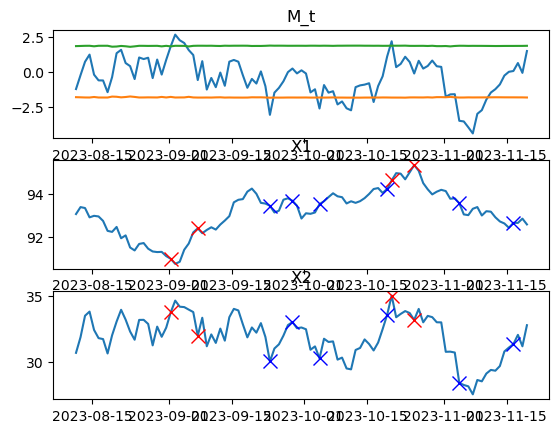

In [18]:
N_3, alpha_3, beta_3, rho_3, sigma_M_3, sigma_R_3, sigma_X_3 = 600, 5, 0.3, 0.7, 0.9, 0.1, 0.003
params_3 = N_3, alpha_3, beta_3, rho_3, sigma_M_3, sigma_R_3, sigma_X_3
generator_3 = pci_generator(*params_3)
X_3, Y_3, W_3, M_3, R_3 = generator_3.generate_pci()

window_size = 500
a, b, c = trading_parameters(X_3, Y_3, window_size=window_size)

print(a.to_string())
print(b.to_string())
print(c[500:].to_string())


fig, axs = plt.subplots(nrows=3, ncols=1)
axs[0].title.set_text("M_t")
axs[1].title.set_text("X1")
axs[2].title.set_text("X2")

axs[0].plot(b["M_t"])
axs[0].plot(-2*a["sigma_M"])
axs[0].plot(2*a["sigma_M"])

axs[1].plot(c["X1"][window_size-1:])
axs[1].plot(b["X1: Short Open Price"], marker="x", color="red", markersize=10)
axs[1].plot(b["X1: Short Close Price"], marker="x", color="red", markersize=10)
axs[1].plot(b["X1: Long Open Price"], marker="x", color="blue", markersize=10)
axs[1].plot(b["X1: Long Close Price"], marker="x", color="blue", markersize=10)

axs[2].plot(c["X2"][window_size-1:])
axs[2].plot(b["X2: Short Open Price"], marker="x", color="red", markersize=10)
axs[2].plot(b["X2: Short Close Price"], marker="x", color="red", markersize=10)
axs[2].plot(b["X2: Long Open Price"], marker="x", color="blue", markersize=10)
axs[2].plot(b["X2: Long Close Price"], marker="x", color="blue", markersize=10)

plt.show()